In [52]:
import pandas as pd
import numpy as np
from datetime import date
import math
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# PROJECT:O2O优惠券使用预测
## BACKGROUND AND MOTIVATION
电子商务业务中，特别是中国到电子商务平台，像阿里巴巴、拼多多等都非常喜欢用商品优惠券来进行营销，吸引客户。通过给予客户优惠折扣来获取新客户、留住老客户。但在发放优惠券前，通常有一个规划方案，一种最重要的细节就是确定发放多少优惠券、向谁发放。因为这些优惠券实际是交易平台用真金白银去补贴客户，因此商户或者平台希望用户拿到优惠券后会进行消费，而不是闲置，导致资源浪费。现有用户在2016年1月1日至2016年6月30日之间真实线上线下消费行为数据，我们的目的是预测用户在2016年7月领取优惠券后15天以内是否核销（即使用优惠券进行购物）。当我们训练出一个能预测出各个客户使用优惠券的概率后，在下次进行营销时，我们可以优先选择使用优惠券的概率高到用户。

## METHODOLOGY
我们获取用户线下消费和优惠券领取核销行为的纪录表，用户线上点击/消费和优惠券领取核销行为的纪录表，记录的时间区间是2016.01.01至2016.06.30,需要预测的是2016年7月份用户领取优惠劵后是否核销。根据这两份数据表，我们首先对数据集进行划分，然后提取了用户相关的特征、商家相关的特征，优惠劵相关的特征，用户与商家之间的交互特征，以及利用本赛题的leakage得到的其它特征（这部分特征在实际业务中是不可能获取到的）。最后训练了XGBoost模型，并预测出各个用户的概率。

## load data

In [2]:
#1754884 record,1053282 with coupon_id,9738 coupon. date_received:20160101~20160615,date:20160101~20160630, 539438 users, 8415 merchants
off_train = pd.read_csv('data/ccf_offline_stage1_train.csv',header=None)
off_train.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']
#2050 coupon_id. date_received:20160701~20160731, 76309 users(76307 in trainset, 35965 in online_trainset), 1559 merchants(1558 in trainset)
off_test = pd.read_csv('data/ccf_offline_stage1_test_revised.csv',header=None)
off_test.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']
#11429826 record(872357 with coupon_id),762858 user(267448 in off_train)
on_train = pd.read_csv('data/ccf_online_stage1_train.csv',header=None)
on_train.columns = ['user_id','merchant_id','action','coupon_id','discount_rate','date_received','date']




In [3]:
def fill_value(x):
    '''
    Replace missing data with null
    '''
    if math.isnan(x):
        return 'null'
    else:
        return str(int(x))
    
off_train.date = off_train.date.apply(fill_value)
off_train.date_received = off_train.date_received.apply(fill_value)


 Use sliding window method to obtain multiple training data sets

![jupyter](./images/data_split.png)

In [4]:
# Use sliding window method to obtain multiple training data sets
dataset3 = off_test
feature3 = off_train[((off_train.date>='20160315')&(off_train.date<='20160630'))|((off_train.date=='null')&(off_train.date_received>='20160315')&(off_train.date_received<='20160630'))]
dataset2 = off_train[(off_train.date_received>='20160515')&(off_train.date_received<='20160615')]
feature2 = off_train[(off_train.date>='20160201')&(off_train.date<='20160514')|((off_train.date=='null')&(off_train.date_received>='20160201')&(off_train.date_received<='20160514'))]
dataset1 = off_train[(off_train.date_received>='20160414')&(off_train.date_received<='20160514')]
feature1 = off_train[(off_train.date>='20160101')&(off_train.date<='20160413')|((off_train.date=='null')&(off_train.date_received>='20160101')&(off_train.date_received<='20160413'))]




## features project
在预测区间提取用户特征
### other feature
* 用户领取的所有优惠券数目
* 用户领取的特定优惠券数目
* 用户此次之后/前领取的所有优惠券数目
* 用户此次之后/前领取的特定优惠券数目
* 用户上/下一次领取的时间间隔
* 用户领取特定商家的优惠券数目
* 用户领取的不同商家数目
* 用户当天领取的优惠券数目
* 用户当天领取的特定优惠券数目
* 用户领取的所有优惠券种类数目
* 商家被领取的优惠券数目
* 商家被领取的特定优惠券数目
* 商家被多少不同用户领取的数目
* 商家发行的所有优惠券种类数目

#### 对dataset3进行处理

In [5]:
#for dataset3
t = dataset3[['user_id']]
t['this_month_user_receive_all_coupon_count'] = 1
t = t.groupby('user_id').agg('sum').reset_index()

t1 = dataset3[['user_id','coupon_id']]
t1['this_month_user_receive_same_coupon_count'] = 1
t1 = t1.groupby(['user_id','coupon_id']).agg('sum').reset_index()

t2 = dataset3[['user_id','coupon_id','date_received']]
t2.date_received = t2.date_received.astype('str')
t2 = t2.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
t2['receive_number'] = t2.date_received.apply(lambda s:len(s.split(':')))
t2 = t2[t2.receive_number>1]
t2['max_date_received'] = t2.date_received.apply(lambda s:max([int(d) for d in s.split(':')]))
t2['min_date_received'] = t2.date_received.apply(lambda s:min([int(d) for d in s.split(':')]))
t2 = t2[['user_id','coupon_id','max_date_received','min_date_received']]

t3 = dataset3[['user_id','coupon_id','date_received']]
t3 = pd.merge(t3,t2,on=['user_id','coupon_id'],how='left')
t3['this_month_user_receive_same_coupon_lastone'] = t3.max_date_received - t3.date_received
t3['this_month_user_receive_same_coupon_firstone'] = t3.date_received - t3.min_date_received
def is_firstlastone(x):
    if x==0:
        return 1
    elif x>0:
        return 0
    else:
        return -1 #those only receive once

In [6]:
t3.this_month_user_receive_same_coupon_lastone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
t3.this_month_user_receive_same_coupon_firstone = t3.this_month_user_receive_same_coupon_firstone.apply(is_firstlastone)
t3 = t3[['user_id','coupon_id','date_received','this_month_user_receive_same_coupon_lastone','this_month_user_receive_same_coupon_firstone']]

t4 = dataset3[['user_id','date_received']]
t4['this_day_user_receive_all_coupon_count'] = 1
t4 = t4.groupby(['user_id','date_received']).agg('sum').reset_index()

t5 = dataset3[['user_id','coupon_id','date_received']]
t5['this_day_user_receive_same_coupon_count'] = 1
t5 = t5.groupby(['user_id','coupon_id','date_received']).agg('sum').reset_index()

t6 = dataset3[['user_id','coupon_id','date_received']]
t6.date_received = t6.date_received.astype('str')
t6 = t6.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
t6.rename(columns={'date_received':'dates'},inplace=True)

In [7]:
def get_day_gap_before(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))-date(int(d[0:4]),int(d[4:6]),int(d[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)
        
def get_day_gap_after(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (date(int(d[0:4]),int(d[4:6]),int(d[6:8]))-date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)
    

t7 = dataset3[['user_id','coupon_id','date_received']]
t7 = pd.merge(t7,t6,on=['user_id','coupon_id'],how='left')
t7['date_received_date'] = t7.date_received.astype('str') + '-' + t7.dates
t7['day_gap_before'] = t7.date_received_date.apply(get_day_gap_before)
t7['day_gap_after'] = t7.date_received_date.apply(get_day_gap_after)
t7 = t7[['user_id','coupon_id','date_received','day_gap_before','day_gap_after']]

other_feature3 = pd.merge(t1,t,on='user_id')
other_feature3 = pd.merge(other_feature3,t3,on=['user_id','coupon_id'])
other_feature3 = pd.merge(other_feature3,t4,on=['user_id','date_received'])
other_feature3 = pd.merge(other_feature3,t5,on=['user_id','coupon_id','date_received'])
other_feature3 = pd.merge(other_feature3,t7,on=['user_id','coupon_id','date_received'])
other_feature3.to_csv('data/other_feature3.csv',index=None)

#### 对dataset2进行处理

In [8]:
#for dataset2
t = dataset2[['user_id']]
t['this_month_user_receive_all_coupon_count'] = 1
t = t.groupby('user_id').agg('sum').reset_index()

t1 = dataset2[['user_id','coupon_id']]
t1['this_month_user_receive_same_coupon_count'] = 1
t1 = t1.groupby(['user_id','coupon_id']).agg('sum').reset_index()

t2 = dataset2[['user_id','coupon_id','date_received']]
t2.date_received = t2.date_received.astype('str')
t2 = t2.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
t2['receive_number'] = t2.date_received.apply(lambda s:len(s.split(':')))
t2 = t2[t2.receive_number>1]
t2['max_date_received'] = t2.date_received.apply(lambda s:max([int(d) for d in s.split(':')]))
t2['min_date_received'] = t2.date_received.apply(lambda s:min([int(d) for d in s.split(':')]))
t2 = t2[['user_id','coupon_id','max_date_received','min_date_received']]

t3 = dataset2[['user_id','coupon_id','date_received']]
t3 = pd.merge(t3,t2,on=['user_id','coupon_id'],how='left')
t3['this_month_user_receive_same_coupon_lastone'] = t3.max_date_received - t3.date_received.astype('int')
t3['this_month_user_receive_same_coupon_firstone'] = t3.date_received.astype('int') - t3.min_date_received
def is_firstlastone(x):
    if x==0:
        return 1
    elif x>0:
        return 0
    else:
        return -1 #those only receive once
        
t3.this_month_user_receive_same_coupon_lastone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
t3.this_month_user_receive_same_coupon_firstone = t3.this_month_user_receive_same_coupon_firstone.apply(is_firstlastone)
t3 = t3[['user_id','coupon_id','date_received','this_month_user_receive_same_coupon_lastone','this_month_user_receive_same_coupon_firstone']]

t4 = dataset2[['user_id','date_received']]
t4['this_day_user_receive_all_coupon_count'] = 1
t4 = t4.groupby(['user_id','date_received']).agg('sum').reset_index()

t5 = dataset2[['user_id','coupon_id','date_received']]
t5['this_day_user_receive_same_coupon_count'] = 1
t5 = t5.groupby(['user_id','coupon_id','date_received']).agg('sum').reset_index()

t6 = dataset2[['user_id','coupon_id','date_received']]
t6.date_received = t6.date_received.astype('str')
t6 = t6.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
t6.rename(columns={'date_received':'dates'},inplace=True)

def get_day_gap_before(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))-date(int(d[0:4]),int(d[4:6]),int(d[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)
        
def get_day_gap_after(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (date(int(d[0:4]),int(d[4:6]),int(d[6:8]))-date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)
    

t7 = dataset2[['user_id','coupon_id','date_received']]
t7 = pd.merge(t7,t6,on=['user_id','coupon_id'],how='left')
t7['date_received_date'] = t7.date_received.astype('str') + '-' + t7.dates
t7['day_gap_before'] = t7.date_received_date.apply(get_day_gap_before)
t7['day_gap_after'] = t7.date_received_date.apply(get_day_gap_after)
t7 = t7[['user_id','coupon_id','date_received','day_gap_before','day_gap_after']]

other_feature2 = pd.merge(t1,t,on='user_id')
other_feature2 = pd.merge(other_feature2,t3,on=['user_id','coupon_id'])
other_feature2 = pd.merge(other_feature2,t4,on=['user_id','date_received'])
other_feature2 = pd.merge(other_feature2,t5,on=['user_id','coupon_id','date_received'])
other_feature2 = pd.merge(other_feature2,t7,on=['user_id','coupon_id','date_received'])
other_feature2.to_csv('data/other_feature2.csv',index=None)



#### 对dataset1处理

In [9]:
#for dataset1
t = dataset1[['user_id']]
t['this_month_user_receive_all_coupon_count'] = 1
t = t.groupby('user_id').agg('sum').reset_index()

t1 = dataset1[['user_id','coupon_id']]
t1['this_month_user_receive_same_coupon_count'] = 1
t1 = t1.groupby(['user_id','coupon_id']).agg('sum').reset_index()

t2 = dataset1[['user_id','coupon_id','date_received']]
t2.date_received = t2.date_received.astype('str')
t2 = t2.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
t2['receive_number'] = t2.date_received.apply(lambda s:len(s.split(':')))
t2 = t2[t2.receive_number>1]
t2['max_date_received'] = t2.date_received.apply(lambda s:max([int(d) for d in s.split(':')]))
t2['min_date_received'] = t2.date_received.apply(lambda s:min([int(d) for d in s.split(':')]))
t2 = t2[['user_id','coupon_id','max_date_received','min_date_received']]

t3 = dataset1[['user_id','coupon_id','date_received']]
t3 = pd.merge(t3,t2,on=['user_id','coupon_id'],how='left')
t3['this_month_user_receive_same_coupon_lastone'] = t3.max_date_received - t3.date_received.astype('int')
t3['this_month_user_receive_same_coupon_firstone'] = t3.date_received.astype('int') - t3.min_date_received
def is_firstlastone(x):
    if x==0:
        return 1
    elif x>0:
        return 0
    else:
        return -1 #those only receive once
        
t3.this_month_user_receive_same_coupon_lastone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
t3.this_month_user_receive_same_coupon_firstone = t3.this_month_user_receive_same_coupon_firstone.apply(is_firstlastone)
t3 = t3[['user_id','coupon_id','date_received','this_month_user_receive_same_coupon_lastone','this_month_user_receive_same_coupon_firstone']]

t4 = dataset1[['user_id','date_received']]
t4['this_day_user_receive_all_coupon_count'] = 1
t4 = t4.groupby(['user_id','date_received']).agg('sum').reset_index()

t5 = dataset1[['user_id','coupon_id','date_received']]
t5['this_day_user_receive_same_coupon_count'] = 1
t5 = t5.groupby(['user_id','coupon_id','date_received']).agg('sum').reset_index()

t6 = dataset1[['user_id','coupon_id','date_received']]
t6.date_received = t6.date_received.astype('str')
t6 = t6.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
t6.rename(columns={'date_received':'dates'},inplace=True)

def get_day_gap_before(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))-date(int(d[0:4]),int(d[4:6]),int(d[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)
        
def get_day_gap_after(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (date(int(d[0:4]),int(d[4:6]),int(d[6:8]))-date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)
    

t7 = dataset1[['user_id','coupon_id','date_received']]
t7 = pd.merge(t7,t6,on=['user_id','coupon_id'],how='left')
t7['date_received_date'] = t7.date_received.astype('str') + '-' + t7.dates
t7['day_gap_before'] = t7.date_received_date.apply(get_day_gap_before)
t7['day_gap_after'] = t7.date_received_date.apply(get_day_gap_after)
t7 = t7[['user_id','coupon_id','date_received','day_gap_before','day_gap_after']]

other_feature1 = pd.merge(t1,t,on='user_id')
other_feature1 = pd.merge(other_feature1,t3,on=['user_id','coupon_id'])
other_feature1 = pd.merge(other_feature1,t4,on=['user_id','date_received'])
other_feature1 = pd.merge(other_feature1,t5,on=['user_id','coupon_id','date_received'])
other_feature1 = pd.merge(other_feature1,t7,on=['user_id','coupon_id','date_received'])
other_feature1.to_csv('data/other_feature1.csv',index=None)



### coupon related features

提取与优惠券相关对特征

* 优惠券类型(直接优惠为0, 满减为1)
* 优惠券折率
* 满减优惠券的最低消费
* 历史出现次数
* 历史核销次数
* 历史核销率
* 历史核销时间率
* 领取优惠券是一周的第几天
* 领取优惠券是一月的第几天
* 历史上用户领取该优惠券次数
* 历史上用户消费该优惠券次数
* 历史上用户对该优惠券的核销率



In [10]:
def calc_discount_rate(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return float(s[0])
    else:
        return 1.0-float(s[1])/float(s[0])

def get_discount_man(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return 'null'
    else:
        return int(s[0])
        
def get_discount_jian(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return 'null'
    else:
        return int(s[1])

def is_man_jian(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return 0
    else:
        return 1

# for dataset3
dataset3['day_of_week'] = dataset3.date_received.astype('str').apply(lambda x:date(int(x[0:4]),int(x[4:6]),int(x[6:8])).weekday()+1)
dataset3['day_of_month'] = dataset3.date_received.astype('str').apply(lambda x:int(x[6:8]))
dataset3['days_distance'] = dataset3.date_received.astype('str').apply(lambda x:(date(int(x[0:4]),int(x[4:6]),int(x[6:8]))-date(2016,6,30)).days)
dataset3['discount_man'] = dataset3.discount_rate.apply(get_discount_man)
dataset3['discount_jian'] = dataset3.discount_rate.apply(get_discount_jian)
dataset3['is_man_jian'] = dataset3.discount_rate.apply(is_man_jian)
dataset3['discount_rate'] = dataset3.discount_rate.apply(calc_discount_rate)
d = dataset3[['coupon_id']]
d['coupon_count'] = 1
d = d.groupby('coupon_id').agg('sum').reset_index()
dataset3 = pd.merge(dataset3,d,on='coupon_id',how='left')
dataset3.to_csv('data/coupon3_feature.csv',index=None)


# for dataset2
dataset2['day_of_week'] = dataset2.date_received.astype('str').apply(lambda x:date(int(x[0:4]),int(x[4:6]),int(x[6:8])).weekday()+1)
dataset2['day_of_month'] = dataset2.date_received.astype('str').apply(lambda x:int(x[6:8]))
dataset2['days_distance'] = dataset2.date_received.astype('str').apply(lambda x:(date(int(x[0:4]),int(x[4:6]),int(x[6:8]))-date(2016,5,14)).days)
dataset2['discount_man'] = dataset2.discount_rate.apply(get_discount_man)
dataset2['discount_jian'] = dataset2.discount_rate.apply(get_discount_jian)
dataset2['is_man_jian'] = dataset2.discount_rate.apply(is_man_jian)
dataset2['discount_rate'] = dataset2.discount_rate.apply(calc_discount_rate)
d = dataset2[['coupon_id']]
d['coupon_count'] = 1
d = d.groupby('coupon_id').agg('sum').reset_index()
dataset2 = pd.merge(dataset2,d,on='coupon_id',how='left')
dataset2.to_csv('data/coupon2_feature.csv',index=None)


# fordataset1
dataset1['day_of_week'] = dataset1.date_received.astype('str').apply(lambda x:date(int(x[0:4]),int(x[4:6]),int(x[6:8])).weekday()+1)
dataset1['day_of_month'] = dataset1.date_received.astype('str').apply(lambda x:int(x[6:8]))
dataset1['days_distance'] = dataset1.date_received.astype('str').apply(lambda x:(date(int(x[0:4]),int(x[4:6]),int(x[6:8]))-date(2016,4,13)).days)
dataset1['discount_man'] = dataset1.discount_rate.apply(get_discount_man)
dataset1['discount_jian'] = dataset1.discount_rate.apply(get_discount_jian)
dataset1['is_man_jian'] = dataset1.discount_rate.apply(is_man_jian)
dataset1['discount_rate'] = dataset1.discount_rate.apply(calc_discount_rate)
d = dataset1[['coupon_id']]
d['coupon_count'] = 1
d = d.groupby('coupon_id').agg('sum').reset_index()
dataset1 = pd.merge(dataset1,d,on='coupon_id',how='left')
dataset1.to_csv('data/coupon1_feature.csv',index=None)



### merchant related features
提取与商户相关的特征

* 商家优惠券被领取次数
* 商家优惠券被领取后不核销次数
* 商家优惠券被领取后核销次数
* 商家优惠券被领取后核销率
* 商家优惠券核销的平均/最小/最大消费折率
* 核销商家优惠券的不同用户数量，及其占领取不同的用户比重
* 商家优惠券平均每个用户核销多少张
* 商家被核销过的不同优惠券数量
* 商家被核销过的不同优惠券数量占所有领取过的不同优惠券数量的比重
* 商家平均每种优惠券核销多少张
* 商家被核销优惠券的平均时间率
* 商家被核销优惠券中的平均/最小/最大用户-商家距离

#### 对dataset3处理

In [11]:
#for dataset3
merchant3 = feature3[['merchant_id','coupon_id','distance','date_received','date']]

t = merchant3[['merchant_id']]
t.drop_duplicates(inplace=True)

t1 = merchant3[merchant3.date!='null'][['merchant_id']]
t1['total_sales'] = 1
t1 = t1.groupby('merchant_id').agg('sum').reset_index()

t2 = merchant3[(merchant3.date!='null')&(merchant3.coupon_id!='null')][['merchant_id']]
t2['sales_use_coupon'] = 1
t2 = t2.groupby('merchant_id').agg('sum').reset_index()

t3 = merchant3[merchant3.coupon_id!='null'][['merchant_id']]
t3['total_coupon'] = 1
t3 = t3.groupby('merchant_id').agg('sum').reset_index()

t4 = merchant3[(merchant3.date!='null')&(merchant3.coupon_id!='null')][['merchant_id','distance']]
t4.replace('null',-1,inplace=True)
t4.distance = t4.distance.fillna(-1)
t4.distance = t4.distance.astype('int')
t4.replace(-1,np.nan,inplace=True)
t5 = t4.groupby('merchant_id').agg('min').reset_index()
t5.rename(columns={'distance':'merchant_min_distance'},inplace=True)

t6 = t4.groupby('merchant_id').agg('max').reset_index()
t6.rename(columns={'distance':'merchant_max_distance'},inplace=True)

t7 = t4.groupby('merchant_id').agg('mean').reset_index()
t7.rename(columns={'distance':'merchant_mean_distance'},inplace=True)

t8 = t4.groupby('merchant_id').agg('median').reset_index()
t8.rename(columns={'distance':'merchant_median_distance'},inplace=True)

merchant3_feature = pd.merge(t,t1,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t2,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t3,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t5,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t6,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t7,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t8,on='merchant_id',how='left')
merchant3_feature.sales_use_coupon = merchant3_feature.sales_use_coupon.replace(np.nan,0) #fillna with 0
merchant3_feature['merchant_coupon_transfer_rate'] = merchant3_feature.sales_use_coupon.astype('float') / merchant3_feature.total_coupon
merchant3_feature['coupon_rate'] = merchant3_feature.sales_use_coupon.astype('float') / merchant3_feature.total_sales
merchant3_feature.total_coupon = merchant3_feature.total_coupon.replace(np.nan,0) #fillna with 0
merchant3_feature.to_csv('data/merchant3_feature.csv',index=None)



#### 对dataset2处理

In [12]:
#for dataset2
merchant2 = feature2[['merchant_id','coupon_id','distance','date_received','date']]

t = merchant2[['merchant_id']]
t.drop_duplicates(inplace=True)

t1 = merchant2[merchant2.date!='null'][['merchant_id']]
t1['total_sales'] = 1
t1 = t1.groupby('merchant_id').agg('sum').reset_index()

t2 = merchant2[(merchant2.date!='null')&(merchant2.coupon_id!='null')][['merchant_id']]
t2['sales_use_coupon'] = 1
t2 = t2.groupby('merchant_id').agg('sum').reset_index()

t3 = merchant2[merchant2.coupon_id!='null'][['merchant_id']]
t3['total_coupon'] = 1
t3 = t3.groupby('merchant_id').agg('sum').reset_index()

t4 = merchant2[(merchant2.date!='null')&(merchant2.coupon_id!='null')][['merchant_id','distance']]
t4.replace('null',-1,inplace=True)
t4.distance = t4.distance.fillna(-1)
t4.distance = t4.distance.astype('int')
t4.replace(-1,np.nan,inplace=True)
t5 = t4.groupby('merchant_id').agg('min').reset_index()
t5.rename(columns={'distance':'merchant_min_distance'},inplace=True)

t6 = t4.groupby('merchant_id').agg('max').reset_index()
t6.rename(columns={'distance':'merchant_max_distance'},inplace=True)

t7 = t4.groupby('merchant_id').agg('mean').reset_index()
t7.rename(columns={'distance':'merchant_mean_distance'},inplace=True)

t8 = t4.groupby('merchant_id').agg('median').reset_index()
t8.rename(columns={'distance':'merchant_median_distance'},inplace=True)

merchant2_feature = pd.merge(t,t1,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t2,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t3,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t5,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t6,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t7,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t8,on='merchant_id',how='left')
merchant2_feature.sales_use_coupon = merchant2_feature.sales_use_coupon.replace(np.nan,0) #fillna with 0
merchant2_feature['merchant_coupon_transfer_rate'] = merchant2_feature.sales_use_coupon.astype('float') / merchant2_feature.total_coupon
merchant2_feature['coupon_rate'] = merchant2_feature.sales_use_coupon.astype('float') / merchant2_feature.total_sales
merchant2_feature.total_coupon = merchant2_feature.total_coupon.replace(np.nan,0) #fillna with 0
merchant2_feature.to_csv('data/merchant2_feature.csv',index=None)


#### 对dataset1处理

In [13]:
#for dataset1
merchant1 = feature1[['merchant_id','coupon_id','distance','date_received','date']]

t = merchant1[['merchant_id']]
t.drop_duplicates(inplace=True)

t1 = merchant1[merchant1.date!='null'][['merchant_id']]
t1['total_sales'] = 1
t1 = t1.groupby('merchant_id').agg('sum').reset_index()

t2 = merchant1[(merchant1.date!='null')&(merchant1.coupon_id!='null')][['merchant_id']]
t2['sales_use_coupon'] = 1
t2 = t2.groupby('merchant_id').agg('sum').reset_index()

t3 = merchant1[merchant1.coupon_id!='null'][['merchant_id']]
t3['total_coupon'] = 1
t3 = t3.groupby('merchant_id').agg('sum').reset_index()

t4 = merchant1[(merchant1.date!='null')&(merchant1.coupon_id!='null')][['merchant_id','distance']]
t4.replace('null',-1,inplace=True)
t4.distance = t4.distance.fillna(-1)
t4.distance = t4.distance.astype('int')
t4.replace(-1,np.nan,inplace=True)
t5 = t4.groupby('merchant_id').agg('min').reset_index()
t5.rename(columns={'distance':'merchant_min_distance'},inplace=True)

t6 = t4.groupby('merchant_id').agg('max').reset_index()
t6.rename(columns={'distance':'merchant_max_distance'},inplace=True)

t7 = t4.groupby('merchant_id').agg('mean').reset_index()
t7.rename(columns={'distance':'merchant_mean_distance'},inplace=True)

t8 = t4.groupby('merchant_id').agg('median').reset_index()
t8.rename(columns={'distance':'merchant_median_distance'},inplace=True)

#### 汇总特征

In [14]:
merchant1_feature = pd.merge(t,t1,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t2,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t3,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t5,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t6,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t7,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t8,on='merchant_id',how='left')
merchant1_feature.sales_use_coupon = merchant1_feature.sales_use_coupon.replace(np.nan,0) #fillna with 0
merchant1_feature['merchant_coupon_transfer_rate'] = merchant1_feature.sales_use_coupon.astype('float') / merchant1_feature.total_coupon
merchant1_feature['coupon_rate'] = merchant1_feature.sales_use_coupon.astype('float') / merchant1_feature.total_sales
merchant1_feature.total_coupon = merchant1_feature.total_coupon.replace(np.nan,0) #fillna with 0
merchant1_feature.to_csv('data/merchant1_feature.csv',index=None)


### user related feature

提取与用户相关的特征

* 用户线下相关的特征
 * 用户领取优惠券次数
 * 用户获得优惠券但没有消费的次数
 * 用户获得优惠券并核销次数
 * 用户领取优惠券后进行核销率
 * 用户满减的优惠券核销率
 * 用户核销满050/50200/200~500减的优惠券占所有核销优惠券的比重
 * 用户核销优惠券的平均/最低/最高消费折率
 * 用户核销过优惠券的不同商家数量，及其占所有不同商家的比重
 * 用户核销过的不同优惠券数量，及其占所有不同优惠券的比重
 * 用户平均核销每个商家多少张优惠券
 * 用户核销优惠券中的平均/最大/最小用户-商家距离
 
* 用户线上相关的特征
 * 用户线上操作次数
 * 用户线上点击率
 * 用户线上购买率
 * 用户线上领取率
 * 用户线上不消费次数
 * 用户线上优惠券核销次数
 * 用户线上优惠券核销率
 * 用户线下不消费次数占线上线下总的不消费次数的比重
 * 用户线下的优惠券核销次数占线上线下总的优惠券核销次数的比重
 * 用户线下领取的记录数量占总的记录数量的比重

#### 对dataset3处理

In [15]:
def get_user_date_datereceived_gap(s):
    s = s.split(':')
    return (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8])) - date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days

#for dataset3
user3 = feature3[['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']]

t = user3[['user_id']]
t.drop_duplicates(inplace=True)

t1 = user3[user3.date!='null'][['user_id','merchant_id']]
t1.drop_duplicates(inplace=True)
t1.merchant_id = 1
t1 = t1.groupby('user_id').agg('sum').reset_index()
t1.rename(columns={'merchant_id':'count_merchant'},inplace=True)

t2 = user3[(user3.date!='null')&(user3.coupon_id!='null')][['user_id','distance']]
t2.replace('null',-1,inplace=True)
t2.distance = t2.distance.fillna(-1)
t2.distance = t2.distance.astype('int')
t2.replace(-1,np.nan,inplace=True)
t3 = t2.groupby('user_id').agg('min').reset_index()
t3.rename(columns={'distance':'user_min_distance'},inplace=True)

t4 = t2.groupby('user_id').agg('max').reset_index()
t4.rename(columns={'distance':'user_max_distance'},inplace=True)

t5 = t2.groupby('user_id').agg('mean').reset_index()
t5.rename(columns={'distance':'user_mean_distance'},inplace=True)

t6 = t2.groupby('user_id').agg('median').reset_index()
t6.rename(columns={'distance':'user_median_distance'},inplace=True)

t7 = user3[(user3.date!='null')&(user3.coupon_id!='null')][['user_id']]
t7['buy_use_coupon'] = 1
t7 = t7.groupby('user_id').agg('sum').reset_index()

t8 = user3[user3.date!='null'][['user_id']]
t8['buy_total'] = 1
t8 = t8.groupby('user_id').agg('sum').reset_index()

t9 = user3[user3.coupon_id!='null'][['user_id']]
t9['coupon_received'] = 1
t9 = t9.groupby('user_id').agg('sum').reset_index()

t10 = user3[(user3.date_received!='null')&(user3.date!='null')][['user_id','date_received','date']]
t10['user_date_datereceived_gap'] = t10.date + ':' + t10.date_received
t10.user_date_datereceived_gap = t10.user_date_datereceived_gap.apply(get_user_date_datereceived_gap)
t10 = t10[['user_id','user_date_datereceived_gap']]

t11 = t10.groupby('user_id').agg('mean').reset_index()
t11.rename(columns={'user_date_datereceived_gap':'avg_user_date_datereceived_gap'},inplace=True)
t12 = t10.groupby('user_id').agg('min').reset_index()
t12.rename(columns={'user_date_datereceived_gap':'min_user_date_datereceived_gap'},inplace=True)
t13 = t10.groupby('user_id').agg('max').reset_index()
t13.rename(columns={'user_date_datereceived_gap':'max_user_date_datereceived_gap'},inplace=True)

In [16]:
# 汇总特征
user3_feature = pd.merge(t,t1,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t3,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t4,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t5,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t6,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t7,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t8,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t9,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t11,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t12,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t13,on='user_id',how='left')
user3_feature.count_merchant = user3_feature.count_merchant.replace(np.nan,0)
user3_feature.buy_use_coupon = user3_feature.buy_use_coupon.replace(np.nan,0)
user3_feature['buy_use_coupon_rate'] = user3_feature.buy_use_coupon.astype('float') / user3_feature.buy_total.astype('float')
user3_feature['user_coupon_transfer_rate'] = user3_feature.buy_use_coupon.astype('float') / user3_feature.coupon_received.astype('float')
user3_feature.buy_total = user3_feature.buy_total.replace(np.nan,0)
user3_feature.coupon_received = user3_feature.coupon_received.replace(np.nan,0)
user3_feature.to_csv('data/user3_feature.csv',index=None)


#### 对dataset2处理

In [17]:
#for dataset2
user2 = feature2[['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']]

t = user2[['user_id']]
t.drop_duplicates(inplace=True)

t1 = user2[user2.date!='null'][['user_id','merchant_id']]
t1.drop_duplicates(inplace=True)
t1.merchant_id = 1
t1 = t1.groupby('user_id').agg('sum').reset_index()
t1.rename(columns={'merchant_id':'count_merchant'},inplace=True)

t2 = user2[(user2.date!='null')&(user2.coupon_id!='null')][['user_id','distance']]
t2.replace('null',-1,inplace=True)
t2.distance = t2.distance.fillna(-1)
t2.distance = t2.distance.astype('int')
t2.replace(-1,np.nan,inplace=True)
t3 = t2.groupby('user_id').agg('min').reset_index()
t3.rename(columns={'distance':'user_min_distance'},inplace=True)

t4 = t2.groupby('user_id').agg('max').reset_index()
t4.rename(columns={'distance':'user_max_distance'},inplace=True)

t5 = t2.groupby('user_id').agg('mean').reset_index()
t5.rename(columns={'distance':'user_mean_distance'},inplace=True)

t6 = t2.groupby('user_id').agg('median').reset_index()
t6.rename(columns={'distance':'user_median_distance'},inplace=True)

t7 = user2[(user2.date!='null')&(user2.coupon_id!='null')][['user_id']]
t7['buy_use_coupon'] = 1
t7 = t7.groupby('user_id').agg('sum').reset_index()

t8 = user2[user2.date!='null'][['user_id']]
t8['buy_total'] = 1
t8 = t8.groupby('user_id').agg('sum').reset_index()

t9 = user2[user2.coupon_id!='null'][['user_id']]
t9['coupon_received'] = 1
t9 = t9.groupby('user_id').agg('sum').reset_index()

t10 = user2[(user2.date_received!='null')&(user2.date!='null')][['user_id','date_received','date']]
t10['user_date_datereceived_gap'] = t10.date + ':' + t10.date_received
t10.user_date_datereceived_gap = t10.user_date_datereceived_gap.apply(get_user_date_datereceived_gap)
t10 = t10[['user_id','user_date_datereceived_gap']]

t11 = t10.groupby('user_id').agg('mean').reset_index()
t11.rename(columns={'user_date_datereceived_gap':'avg_user_date_datereceived_gap'},inplace=True)
t12 = t10.groupby('user_id').agg('min').reset_index()
t12.rename(columns={'user_date_datereceived_gap':'min_user_date_datereceived_gap'},inplace=True)
t13 = t10.groupby('user_id').agg('max').reset_index()
t13.rename(columns={'user_date_datereceived_gap':'max_user_date_datereceived_gap'},inplace=True)

In [18]:
# 汇总特征
user2_feature = pd.merge(t,t1,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t3,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t4,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t5,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t6,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t7,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t8,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t9,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t11,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t12,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t13,on='user_id',how='left')
user2_feature.count_merchant = user2_feature.count_merchant.replace(np.nan,0)
user2_feature.buy_use_coupon = user2_feature.buy_use_coupon.replace(np.nan,0)
user2_feature['buy_use_coupon_rate'] = user2_feature.buy_use_coupon.astype('float') / user2_feature.buy_total.astype('float')
user2_feature['user_coupon_transfer_rate'] = user2_feature.buy_use_coupon.astype('float') / user2_feature.coupon_received.astype('float')
user2_feature.buy_total = user2_feature.buy_total.replace(np.nan,0)
user2_feature.coupon_received = user2_feature.coupon_received.replace(np.nan,0)
user2_feature.to_csv('data/user2_feature.csv',index=None)



#### 对dataset1处理

In [19]:
#for dataset1
user1 = feature1[['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']]

t = user1[['user_id']]
t.drop_duplicates(inplace=True)

t1 = user1[user1.date!='null'][['user_id','merchant_id']]
t1.drop_duplicates(inplace=True)
t1.merchant_id = 1
t1 = t1.groupby('user_id').agg('sum').reset_index()
t1.rename(columns={'merchant_id':'count_merchant'},inplace=True)

t2 = user1[(user1.date!='null')&(user1.coupon_id!='null')][['user_id','distance']]
t2.replace('null',-1,inplace=True)
t2.distance = t2.distance.fillna(-1)
t2.distance = t2.distance.astype('int')
t2.replace(-1,np.nan,inplace=True)
t3 = t2.groupby('user_id').agg('min').reset_index()
t3.rename(columns={'distance':'user_min_distance'},inplace=True)

t4 = t2.groupby('user_id').agg('max').reset_index()
t4.rename(columns={'distance':'user_max_distance'},inplace=True)

t5 = t2.groupby('user_id').agg('mean').reset_index()
t5.rename(columns={'distance':'user_mean_distance'},inplace=True)

t6 = t2.groupby('user_id').agg('median').reset_index()
t6.rename(columns={'distance':'user_median_distance'},inplace=True)

t7 = user1[(user1.date!='null')&(user1.coupon_id!='null')][['user_id']]
t7['buy_use_coupon'] = 1
t7 = t7.groupby('user_id').agg('sum').reset_index()

t8 = user1[user1.date!='null'][['user_id']]
t8['buy_total'] = 1
t8 = t8.groupby('user_id').agg('sum').reset_index()

t9 = user1[user1.coupon_id!='null'][['user_id']]
t9['coupon_received'] = 1
t9 = t9.groupby('user_id').agg('sum').reset_index()

t10 = user1[(user1.date_received!='null')&(user1.date!='null')][['user_id','date_received','date']]
t10['user_date_datereceived_gap'] = t10.date + ':' + t10.date_received
t10.user_date_datereceived_gap = t10.user_date_datereceived_gap.apply(get_user_date_datereceived_gap)
t10 = t10[['user_id','user_date_datereceived_gap']]

t11 = t10.groupby('user_id').agg('mean').reset_index()
t11.rename(columns={'user_date_datereceived_gap':'avg_user_date_datereceived_gap'},inplace=True)
t12 = t10.groupby('user_id').agg('min').reset_index()
t12.rename(columns={'user_date_datereceived_gap':'min_user_date_datereceived_gap'},inplace=True)
t13 = t10.groupby('user_id').agg('max').reset_index()
t13.rename(columns={'user_date_datereceived_gap':'max_user_date_datereceived_gap'},inplace=True)



In [20]:
# 汇总特征
user1_feature = pd.merge(t,t1,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t3,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t4,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t5,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t6,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t7,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t8,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t9,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t11,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t12,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t13,on='user_id',how='left')
user1_feature.count_merchant = user1_feature.count_merchant.replace(np.nan,0)
user1_feature.buy_use_coupon = user1_feature.buy_use_coupon.replace(np.nan,0)
user1_feature['buy_use_coupon_rate'] = user1_feature.buy_use_coupon.astype('float') / user1_feature.buy_total.astype('float')
user1_feature['user_coupon_transfer_rate'] = user1_feature.buy_use_coupon.astype('float') / user1_feature.coupon_received.astype('float')
user1_feature.buy_total = user1_feature.buy_total.replace(np.nan,0)
user1_feature.coupon_received = user1_feature.coupon_received.replace(np.nan,0)
user1_feature.to_csv('data/user1_feature.csv',index=None)

### user_merchant related feature
提取用户-商家交互的特征
 * 用户领取商家的优惠券次数
 * 用户领取商家的优惠券后不核销次数
 * 用户领取商家的优惠券后核销次数
 * 用户领取商家的优惠券后核销率
 * 用户对每个商家的不核销次数占用户总的不核销次数的比重
 * 用户对每个商家的优惠券核销次数占用户总的核销次数的比重
 * 用户对每个商家的不核销次数占商家总的不核销次数的比重
 * 用户对每个商家的优惠券核销次数占商家总的核销次数的比重

#### 对dataset3处理

In [21]:
#for dataset3
all_user_merchant = feature3[['user_id','merchant_id']]
all_user_merchant.drop_duplicates(inplace=True)

t = feature3[['user_id','merchant_id','date']]
t = t[t.date!='null'][['user_id','merchant_id']]
t['user_merchant_buy_total'] = 1
t = t.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t.drop_duplicates(inplace=True)

t1 = feature3[['user_id','merchant_id','coupon_id']]
t1 = t1[t1.coupon_id!='null'][['user_id','merchant_id']]
t1['user_merchant_received'] = 1
t1 = t1.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t1.drop_duplicates(inplace=True)

t2 = feature3[['user_id','merchant_id','date','date_received']]
t2 = t2[(t2.date!='null')&(t2.date_received!='null')][['user_id','merchant_id']]
t2['user_merchant_buy_use_coupon'] = 1
t2 = t2.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t2.drop_duplicates(inplace=True)

t3 = feature3[['user_id','merchant_id']]
t3['user_merchant_any'] = 1
t3 = t3.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t3.drop_duplicates(inplace=True)

t4 = feature3[['user_id','merchant_id','date','coupon_id']]
t4 = t4[(t4.date!='null')&(t4.coupon_id=='null')][['user_id','merchant_id']]
t4['user_merchant_buy_common'] = 1
t4 = t4.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t4.drop_duplicates(inplace=True)

user_merchant3 = pd.merge(all_user_merchant,t,on=['user_id','merchant_id'],how='left')
user_merchant3 = pd.merge(user_merchant3,t1,on=['user_id','merchant_id'],how='left')
user_merchant3 = pd.merge(user_merchant3,t2,on=['user_id','merchant_id'],how='left')
user_merchant3 = pd.merge(user_merchant3,t3,on=['user_id','merchant_id'],how='left')
user_merchant3 = pd.merge(user_merchant3,t4,on=['user_id','merchant_id'],how='left')
user_merchant3.user_merchant_buy_use_coupon = user_merchant3.user_merchant_buy_use_coupon.replace(np.nan,0)
user_merchant3.user_merchant_buy_common = user_merchant3.user_merchant_buy_common.replace(np.nan,0)
user_merchant3['user_merchant_coupon_transfer_rate'] = user_merchant3.user_merchant_buy_use_coupon.astype('float') / user_merchant3.user_merchant_received.astype('float')
user_merchant3['user_merchant_coupon_buy_rate'] = user_merchant3.user_merchant_buy_use_coupon.astype('float') / user_merchant3.user_merchant_buy_total.astype('float')
user_merchant3['user_merchant_rate'] = user_merchant3.user_merchant_buy_total.astype('float') / user_merchant3.user_merchant_any.astype('float')
user_merchant3['user_merchant_common_buy_rate'] = user_merchant3.user_merchant_buy_common.astype('float') / user_merchant3.user_merchant_buy_total.astype('float')
user_merchant3.to_csv('data/user_merchant3.csv',index=None)


#### 对dataset2处理

In [22]:
#for dataset2
all_user_merchant = feature2[['user_id','merchant_id']]
all_user_merchant.drop_duplicates(inplace=True)

t = feature2[['user_id','merchant_id','date']]
t = t[t.date!='null'][['user_id','merchant_id']]
t['user_merchant_buy_total'] = 1
t = t.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t.drop_duplicates(inplace=True)

t1 = feature2[['user_id','merchant_id','coupon_id']]
t1 = t1[t1.coupon_id!='null'][['user_id','merchant_id']]
t1['user_merchant_received'] = 1
t1 = t1.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t1.drop_duplicates(inplace=True)

t2 = feature2[['user_id','merchant_id','date','date_received']]
t2 = t2[(t2.date!='null')&(t2.date_received!='null')][['user_id','merchant_id']]
t2['user_merchant_buy_use_coupon'] = 1
t2 = t2.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t2.drop_duplicates(inplace=True)

t3 = feature2[['user_id','merchant_id']]
t3['user_merchant_any'] = 1
t3 = t3.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t3.drop_duplicates(inplace=True)

t4 = feature2[['user_id','merchant_id','date','coupon_id']]
t4 = t4[(t4.date!='null')&(t4.coupon_id=='null')][['user_id','merchant_id']]
t4['user_merchant_buy_common'] = 1
t4 = t4.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t4.drop_duplicates(inplace=True)

user_merchant2 = pd.merge(all_user_merchant,t,on=['user_id','merchant_id'],how='left')
user_merchant2 = pd.merge(user_merchant2,t1,on=['user_id','merchant_id'],how='left')
user_merchant2 = pd.merge(user_merchant2,t2,on=['user_id','merchant_id'],how='left')
user_merchant2 = pd.merge(user_merchant2,t3,on=['user_id','merchant_id'],how='left')
user_merchant2 = pd.merge(user_merchant2,t4,on=['user_id','merchant_id'],how='left')
user_merchant2.user_merchant_buy_use_coupon = user_merchant2.user_merchant_buy_use_coupon.replace(np.nan,0)
user_merchant2.user_merchant_buy_common = user_merchant2.user_merchant_buy_common.replace(np.nan,0)
user_merchant2['user_merchant_coupon_transfer_rate'] = user_merchant2.user_merchant_buy_use_coupon.astype('float') / user_merchant2.user_merchant_received.astype('float')
user_merchant2['user_merchant_coupon_buy_rate'] = user_merchant2.user_merchant_buy_use_coupon.astype('float') / user_merchant2.user_merchant_buy_total.astype('float')
user_merchant2['user_merchant_rate'] = user_merchant2.user_merchant_buy_total.astype('float') / user_merchant2.user_merchant_any.astype('float')
user_merchant2['user_merchant_common_buy_rate'] = user_merchant2.user_merchant_buy_common.astype('float') / user_merchant2.user_merchant_buy_total.astype('float')
user_merchant2.to_csv('data/user_merchant2.csv',index=None)



#### 对dataset1处理

In [23]:
#for dataset1
all_user_merchant = feature1[['user_id','merchant_id']]
all_user_merchant.drop_duplicates(inplace=True)

t = feature1[['user_id','merchant_id','date']]
t = t[t.date!='null'][['user_id','merchant_id']]
t['user_merchant_buy_total'] = 1
t = t.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t.drop_duplicates(inplace=True)

t1 = feature1[['user_id','merchant_id','coupon_id']]
t1 = t1[t1.coupon_id!='null'][['user_id','merchant_id']]
t1['user_merchant_received'] = 1
t1 = t1.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t1.drop_duplicates(inplace=True)

t2 = feature1[['user_id','merchant_id','date','date_received']]
t2 = t2[(t2.date!='null')&(t2.date_received!='null')][['user_id','merchant_id']]
t2['user_merchant_buy_use_coupon'] = 1
t2 = t2.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t2.drop_duplicates(inplace=True)

t3 = feature1[['user_id','merchant_id']]
t3['user_merchant_any'] = 1
t3 = t3.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t3.drop_duplicates(inplace=True)

t4 = feature1[['user_id','merchant_id','date','coupon_id']]
t4 = t4[(t4.date!='null')&(t4.coupon_id=='null')][['user_id','merchant_id']]
t4['user_merchant_buy_common'] = 1
t4 = t4.groupby(['user_id','merchant_id']).agg('sum').reset_index()

user_merchant1 = pd.merge(all_user_merchant,t,on=['user_id','merchant_id'],how='left')
user_merchant1 = pd.merge(user_merchant1,t1,on=['user_id','merchant_id'],how='left')
user_merchant1 = pd.merge(user_merchant1,t2,on=['user_id','merchant_id'],how='left')
user_merchant1 = pd.merge(user_merchant1,t3,on=['user_id','merchant_id'],how='left')
user_merchant1 = pd.merge(user_merchant1,t4,on=['user_id','merchant_id'],how='left')
user_merchant1.user_merchant_buy_use_coupon = user_merchant1.user_merchant_buy_use_coupon.replace(np.nan,0)
user_merchant1.user_merchant_buy_common = user_merchant1.user_merchant_buy_common.replace(np.nan,0)
user_merchant1['user_merchant_coupon_transfer_rate'] = user_merchant1.user_merchant_buy_use_coupon.astype('float') / user_merchant1.user_merchant_received.astype('float')
user_merchant1['user_merchant_coupon_buy_rate'] = user_merchant1.user_merchant_buy_use_coupon.astype('float') / user_merchant1.user_merchant_buy_total.astype('float')
user_merchant1['user_merchant_rate'] = user_merchant1.user_merchant_buy_total.astype('float') / user_merchant1.user_merchant_any.astype('float')
user_merchant1['user_merchant_common_buy_rate'] = user_merchant1.user_merchant_buy_common.astype('float') / user_merchant1.user_merchant_buy_total.astype('float')
user_merchant1.to_csv('data/user_merchant1.csv',index=None)

## generate training and testing set
生成训练集和测试集
### dataset3

In [24]:
def get_label(s):
    s = s.split(':')
    if s[0]=='null':
        return 0
    elif (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8]))-date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days<=15:
        return 1
    else:
        return -1
    
# load features data
coupon3 = pd.read_csv('data/coupon3_feature.csv')
merchant3 = pd.read_csv('data/merchant3_feature.csv')
user3 = pd.read_csv('data/user3_feature.csv')
user_merchant3 = pd.read_csv('data/user_merchant3.csv')
other_feature3 = pd.read_csv('data/other_feature3.csv')
dataset3 = pd.merge(coupon3,merchant3,on='merchant_id',how='left')
dataset3 = pd.merge(dataset3,user3,on='user_id',how='left')
dataset3 = pd.merge(dataset3,user_merchant3,on=['user_id','merchant_id'],how='left')
dataset3 = pd.merge(dataset3,other_feature3,on=['user_id','coupon_id','date_received'],how='left')
dataset3.drop_duplicates(inplace=True)

print(dataset3.shape)

dataset3.user_merchant_buy_total = dataset3.user_merchant_buy_total.replace(np.nan,0)
dataset3.user_merchant_any = dataset3.user_merchant_any.replace(np.nan,0)
dataset3.user_merchant_received = dataset3.user_merchant_received.replace(np.nan,0)
dataset3['is_weekend'] = dataset3.day_of_week.apply(lambda x:1 if x in (6,7) else 0)
weekday_dummies = pd.get_dummies(dataset3.day_of_week)
weekday_dummies.columns = ['weekday'+str(i+1) for i in range(weekday_dummies.shape[1])]
dataset3 = pd.concat([dataset3,weekday_dummies],axis=1)
dataset3.drop(['merchant_id','day_of_week','coupon_count'],axis=1,inplace=True)
dataset3 = dataset3.replace('null',np.nan)
dataset3.to_csv('data/dataset3.csv',index=None)

(112803, 52)


### dataset2

In [25]:
coupon2 = pd.read_csv('data/coupon2_feature.csv')
merchant2 = pd.read_csv('data/merchant2_feature.csv')
user2 = pd.read_csv('data/user2_feature.csv')
user_merchant2 = pd.read_csv('data/user_merchant2.csv')
other_feature2 = pd.read_csv('data/other_feature2.csv')
dataset2 = pd.merge(coupon2,merchant2,on='merchant_id',how='left')
dataset2 = pd.merge(dataset2,user2,on='user_id',how='left')
dataset2 = pd.merge(dataset2,user_merchant2,on=['user_id','merchant_id'],how='left')
dataset2 = pd.merge(dataset2,other_feature2,on=['user_id','coupon_id','date_received'],how='left')
dataset2.drop_duplicates(inplace=True)
print(dataset2.shape)

dataset2.user_merchant_buy_total = dataset2.user_merchant_buy_total.replace(np.nan,0)
dataset2.user_merchant_any = dataset2.user_merchant_any.replace(np.nan,0)
dataset2.user_merchant_received = dataset2.user_merchant_received.replace(np.nan,0)
dataset2.date = dataset2.date.apply(fill_value)
dataset2['is_weekend'] = dataset2.day_of_week.apply(lambda x:1 if x in (6,7) else 0)
weekday_dummies = pd.get_dummies(dataset2.day_of_week)
weekday_dummies.columns = ['weekday'+str(i+1) for i in range(weekday_dummies.shape[1])]
dataset2 = pd.concat([dataset2,weekday_dummies],axis=1)

dataset2['label'] = dataset2.date.astype('str') + ':' +  dataset2.date_received.astype('str')
dataset2.label = dataset2.label.apply(get_label)
dataset2.drop(['merchant_id','day_of_week','date','date_received','coupon_id','coupon_count'],axis=1,inplace=True)
dataset2 = dataset2.replace('null',np.nan)
dataset2.to_csv('data/dataset2.csv',index=None)

(257126, 53)


### dataset1

In [26]:
coupon1 = pd.read_csv('data/coupon1_feature.csv')
merchant1 = pd.read_csv('data/merchant1_feature.csv')
user1 = pd.read_csv('data/user1_feature.csv')
user_merchant1 = pd.read_csv('data/user_merchant1.csv')
other_feature1 = pd.read_csv('data/other_feature1.csv')
dataset1 = pd.merge(coupon1,merchant1,on='merchant_id',how='left')
dataset1 = pd.merge(dataset1,user1,on='user_id',how='left')
dataset1 = pd.merge(dataset1,user_merchant1,on=['user_id','merchant_id'],how='left')
dataset1 = pd.merge(dataset1,other_feature1,on=['user_id','coupon_id','date_received'],how='left')
dataset1.drop_duplicates(inplace=True)
print(dataset1.shape)

dataset1.user_merchant_buy_total = dataset1.user_merchant_buy_total.replace(np.nan,0)
dataset1.user_merchant_any = dataset1.user_merchant_any.replace(np.nan,0)
dataset1.user_merchant_received = dataset1.user_merchant_received.replace(np.nan,0)
dataset1.date = dataset1.date.apply(fill_value)

dataset1['is_weekend'] = dataset1.day_of_week.apply(lambda x:1 if x in (6,7) else 0)
weekday_dummies = pd.get_dummies(dataset1.day_of_week)
weekday_dummies.columns = ['weekday'+str(i+1) for i in range(weekday_dummies.shape[1])]
dataset1 = pd.concat([dataset1,weekday_dummies],axis=1)
dataset1['label'] = dataset1.date.astype('str') + ':' +  dataset1.date_received.astype('str')
dataset1.label = dataset1.label.apply(get_label)
dataset1.drop(['merchant_id','day_of_week','date','date_received','coupon_id','coupon_count'],axis=1,inplace=True)
dataset1 = dataset1.replace('null',np.nan)
dataset1.to_csv('data/dataset1.csv',index=None)

(136301, 53)


## 建立XGBOOST

train on dataset1, evaluate on dataset2

watchlist = [(dataset1,'train'),(dataset2,'val')]

model = xgb.train(params,dataset1,num_boost_round=3000,evals=watchlist,early_stopping_rounds=300)

In [39]:
dataset1 = pd.read_csv('data/dataset1.csv')
dataset1.label.replace(-1, 0, inplace=True)
dataset2 = pd.read_csv('data/dataset2.csv')
dataset2.label.replace(-1, 0, inplace=True)
dataset3 = pd.read_csv('data/dataset3.csv')

dataset1.drop_duplicates(inplace=True)
dataset2.drop_duplicates(inplace=True)
dataset3.drop_duplicates(inplace=True)

dataset12 = pd.concat([dataset1, dataset2], axis=0)

dataset1_y = dataset1.label
# 'day_gap_before','day_gap_after' cause overfitting, 0.77
dataset1_x = dataset1.drop(
    ['user_id', 'label', 'day_gap_before', 'day_gap_after'], axis=1)
dataset2_y = dataset2.label
dataset2_x = dataset2.drop(
    ['user_id', 'label', 'day_gap_before', 'day_gap_after'], axis=1)
dataset12_y = dataset12.label
dataset12_x = dataset12.drop(
    ['user_id', 'label', 'day_gap_before', 'day_gap_after'], axis=1)
dataset3_preds = dataset3[['user_id', 'coupon_id', 'date_received']]
dataset3_x = dataset3.drop(
    ['user_id', 'coupon_id', 'date_received', 'day_gap_before', 'day_gap_after'], axis=1)

print(dataset1_x.shape, dataset2_x.shape, dataset3_x.shape)

dataset1 = xgb.DMatrix(dataset1_x, label=dataset1_y)
dataset2 = xgb.DMatrix(dataset2_x, label=dataset2_y)
dataset12 = xgb.DMatrix(dataset12_x, label=dataset12_y)
dataset3 = xgb.DMatrix(dataset3_x)

params = {'booster': 'gbtree',
          'objective': 'rank:pairwise',
          'eval_metric': 'auc',
          'gamma': 0.1,
          'min_child_weight': 1.1,
          'max_depth': 5,
          'lambda': 10,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'eta': 0.01,
          'tree_method': 'exact',
          'seed': 0,
          'nthread': 12
          }

# train on dataset1, evaluate on dataset2
#watchlist = [(dataset1,'train'),(dataset2,'val')]
#model = xgb.train(params,dataset1,num_boost_round=300,evals=watchlist,early_stopping_rounds=300)

watchlist = [(dataset12, 'train')]
model = xgb.train(params, dataset12, num_boost_round=300, evals=watchlist)

# predict test set
dataset3_preds['label'] = model.predict(dataset3)
dataset3_preds.label = MinMaxScaler().fit_transform(dataset3_preds.label.values.reshape(-1, 1))
dataset3_preds.sort_values(by=['coupon_id', 'label'], inplace=True)
dataset3_preds.to_csv("xgb_preds.csv", index=None, header=None)
print(dataset3_preds.describe())

# save feature score
feature_score = model.get_fscore()
feature_score = sorted(feature_score.items(), key=lambda x: x[1], reverse=True)
fs = []
for (key, value) in feature_score:
    fs.append("{0},{1}\n".format(key, value))

with open('xgb_feature_score.csv', 'w') as f:
    f.writelines("feature,score\n")
    f.writelines(fs)

(134416, 52) (252481, 52) (112803, 52)
[21:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-auc:0.825418
[21:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-auc:0.843426
[21:13:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-auc:0.846458
[21:13:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	train-auc:0.847899
[21:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[4]	train-auc:0.848336
[21:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[5]	train-auc:0.848044
[21:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[6]	train-auc:0.847238
[21:13:46] src/t

## RESULTS
### 各个特征的重要性排序

In [47]:
feature_score = model.get_fscore()
feature_score = sorted(feature_score.items(), key=lambda x: x[1], reverse=True)
feature_score

[('merchant_mean_distance', 118),
 ('discount_rate', 117),
 ('discount_man', 103),
 ('total_sales', 81),
 ('merchant_coupon_transfer_rate', 65),
 ('user_merchant_buy_total', 61),
 ('discount_jian', 56),
 ('user_merchant_rate', 53),
 ('this_month_user_receive_same_coupon_lastone', 48),
 ('days_distance', 44),
 ('total_coupon', 41),
 ('sales_use_coupon', 34),
 ('user_merchant_coupon_transfer_rate', 32),
 ('this_month_user_receive_same_coupon_count', 29),
 ('user_merchant_coupon_buy_rate', 23),
 ('this_month_user_receive_same_coupon_firstone', 20),
 ('user_merchant_received', 19),
 ('buy_use_coupon', 18),
 ('day_of_month', 18),
 ('this_month_user_receive_all_coupon_count', 13),
 ('distance', 11),
 ('max_user_date_datereceived_gap', 10),
 ('user_coupon_transfer_rate', 7),
 ('this_day_user_receive_same_coupon_count', 7),
 ('user_merchant_any', 7),
 ('user_merchant_buy_use_coupon', 6),
 ('min_user_date_datereceived_gap', 5),
 ('avg_user_date_datereceived_gap', 4),
 ('buy_total', 4),
 ('merch

### ROC曲线

In [49]:
def view_ROC_AUC(y_one_hot, train_Y_proba, model_name):
    train_fpr, train_tpr , thresholds = roc_curve(y_one_hot.ravel(),train_Y_proba.ravel())
    train_auc = auc(train_fpr, train_tpr)
    plt.plot(train_fpr, train_tpr, color = 'r', linewidth = 2, alpha = 0.7, label = u'AUC=%.3f' % train_auc)
    plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
    plt.xlim((-0.01, 1.02))
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.grid( b = True, ls=':')
    plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
    plt.title(u"ROC&AUC ", fontsize=17)
    
    plt.savefig( "{}_ROC_curve&AUC.png".format(model_name), dpi = 500, bbox_inches = 'tight' )
    plt.show()

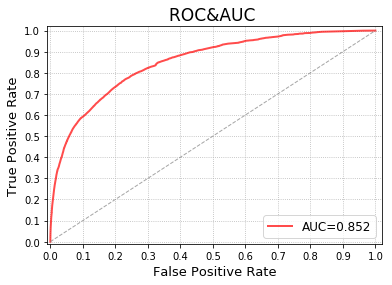

In [53]:
dataset12_preds = model.predict(dataset12)
dataset12_preds = MinMaxScaler().fit_transform(dataset12_preds.reshape(-1, 1))

view_ROC_AUC(dataset12_y, dataset12_preds, model_name = 'XGBOOST')

## CONCLUSION
某一个用户在短时间内领取的优惠券越多，被核销的可能性就很大了。

## REFERENCE

数据链接：https://tianchi.aliyun.com/competition/entrance/231587/information